rnn lstm

load data 

In [18]:
import pandas as pd

# Paths to your training data files
amazon_fashion_path = '/Users/patrickbendorffschwebel/Desktop/Anvendt-kode/anvendt-exam/mappe uden navn 2/AMAZON_FASHION.json'
all_beauty_path = '/Users/patrickbendorffschwebel/Desktop/Anvendt-kode/anvendt-exam/mappe uden navn 2/All_Beauty.json'
clothing_shoes_jewelry_path = '/Users/patrickbendorffschwebel/Desktop/Anvendt-kode/anvendt-exam/mappe uden navn 2/Clothing_Shoes_and_Jewelry.json'


# Number of rows to read from each file
n_rows = 25000

# Load a subset of each training dataset
amazon_fashion = pd.read_json(amazon_fashion_path, lines=True, nrows=n_rows)
all_beauty = pd.read_json(all_beauty_path, lines=True, nrows=n_rows)
clothing_shoes_jewelry = pd.read_json(clothing_shoes_jewelry_path, lines=True, nrows=n_rows)

# Concatenate the datasets
training_data = pd.concat([amazon_fashion, all_beauty, clothing_shoes_jewelry])

data preprocess the text 

In [19]:
import nltk
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re

# Download required resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Set up stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Define text preprocessing function
def preprocess_text(text):
    # Check if the text is a string
    if isinstance(text, str):
        # Lowercase
        text = text.lower()
        
        # Remove special characters/emojis
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

        # Tokenize
        tokens = word_tokenize(text)

        # Lemmatization with POS tagging
        pos_tags = nltk.pos_tag(tokens)
        if pos_tags:
            tag = pos_tags[0][1][0].upper()
        else:
            tag = ''  
        tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
        lemmatized_text = ' '.join([lemmatizer.lemmatize(word, tag_dict.get(tag, wordnet.NOUN)) for word in tokens if word not in stop_words])

        return lemmatized_text
    else:
        # Return an empty string or a placeholder if text is not a string
        return ""

# Apply preprocessing to each review
training_data['processed_reviewText'] = training_data['reviewText'].apply(preprocess_text)

# Remove rows where 'processed_reviewText' is an empty string because of no text
training_data = training_data[training_data['processed_reviewText'] != ""]

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/patrickbendorffschwebel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/patrickbendorffschwebel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/patrickbendorffschwebel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/patrickbendorffschwebel/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


data preparation for modellen

In [20]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Parameters for tokenization
vocab_size = 5000
max_length = 40
embedding_dim = 100

# Tokenize the processed text
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(training_data['processed_reviewText'])
sequences = tokenizer.texts_to_sequences(training_data['processed_reviewText'])
padded_sequences = pad_sequences(sequences, maxlen=max_length)

# Prepare sentiment scores
sentiment_scores = training_data['reviewText'].apply(lambda x: sia.polarity_scores(x)['compound']).values

# Define function for categorizing ratings
def cat_y(overall_rating):
    if overall_rating in [1, 2]:
        return 'low'
    elif overall_rating == 3:
        return 'neutral'
    elif overall_rating in [4, 5]:
        return 'high'

# Prepare labels
labels = training_data['overall'].apply(cat_y)
encoded_labels = pd.get_dummies(labels)

# Calculate class weights to balance the classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weight_dict = dict(enumerate(class_weights))

hyper parameters test, find the best

Processing LSTM Units: 64, Batch Size: 32, Learning Rate: 0.0001
Starting fold 1...
1170/1170 [==============================] - 15s 11ms/step
Fold 1 - Accuracy: 0.783791720867157, F1 Score: 0.8171700493354717
Starting fold 2...
1170/1170 [==============================] - 11s 9ms/step
Fold 2 - Accuracy: 0.7626429796218872, F1 Score: 0.79444050200827
Avg Accuracy: 0.7732173502445221, Avg F1 Score: 0.8058052756718708, Avg Precision: 0.8530258843447047, Avg Recall: 0.773217366196272

Processing LSTM Units: 64, Batch Size: 64, Learning Rate: 0.0001
Starting fold 1...
1170/1170 [==============================] - 11s 9ms/step
Fold 1 - Accuracy: 0.7800764441490173, F1 Score: 0.817881603863706
Starting fold 2...
1170/1170 [==============================] - 14s 11ms/step
Fold 2 - Accuracy: 0.7860579490661621, F1 Score: 0.8018874331771185
Avg Accuracy: 0.7830671966075897, Avg F1 Score: 0.8098845185204122, Avg Precision: 0.850443896112602, Avg Recall: 0.7830671966689295

Best parameters: {'lstm_

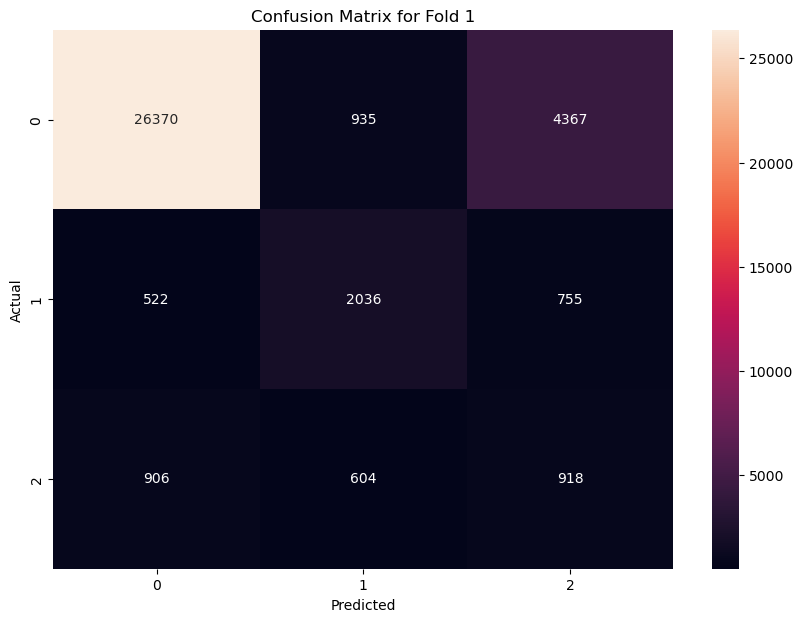

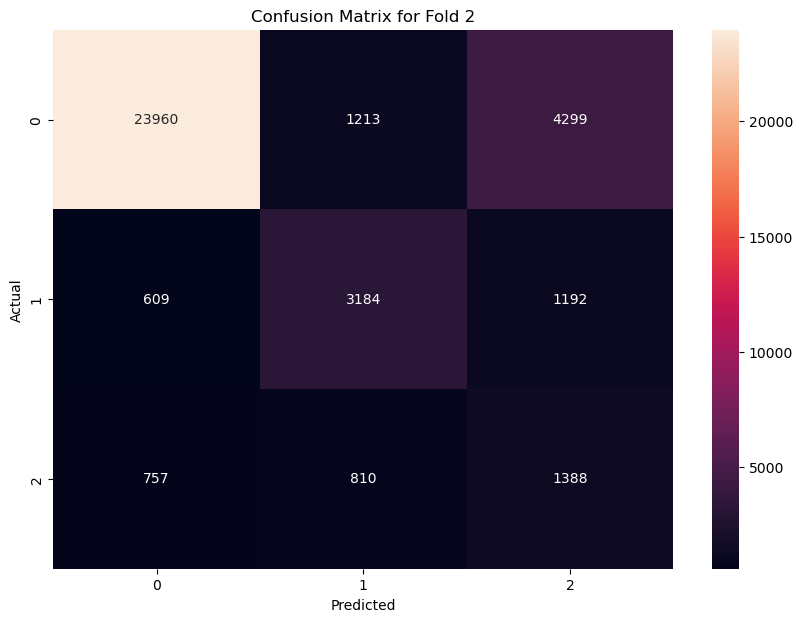

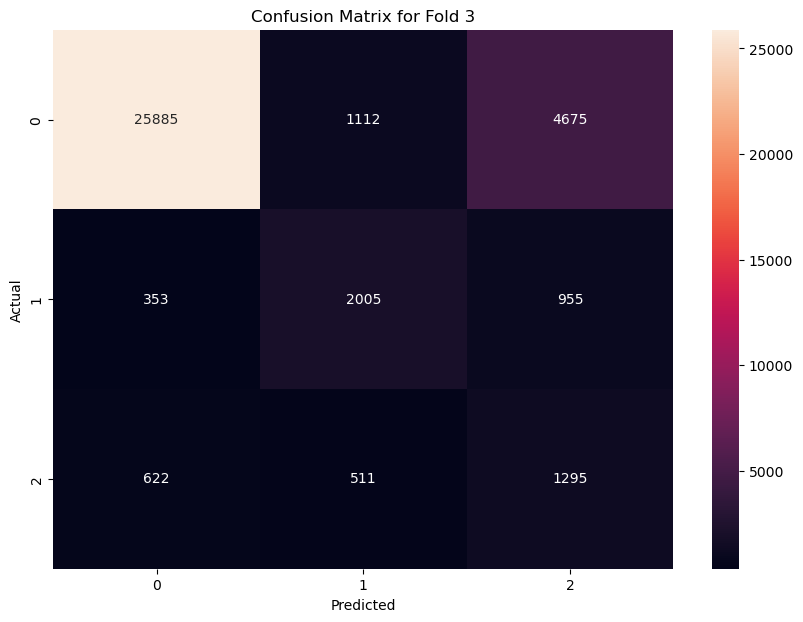

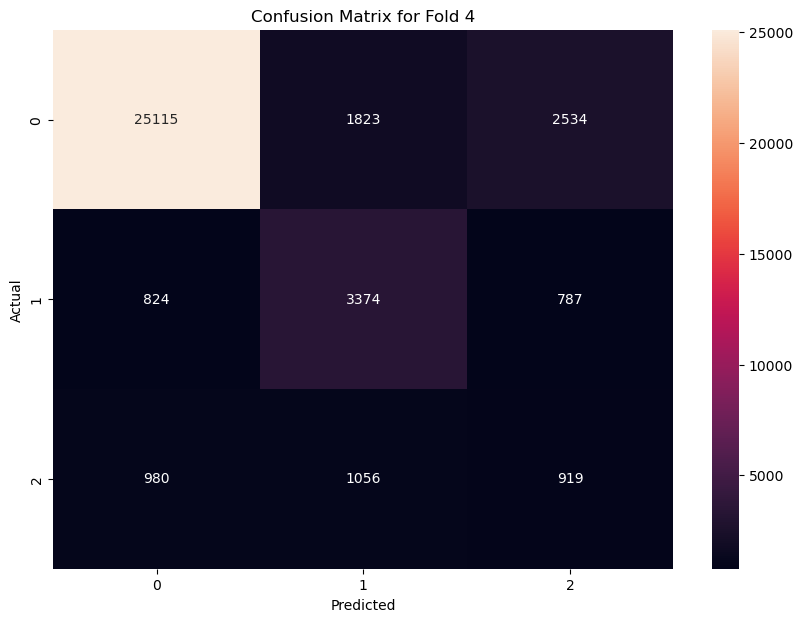

Text: Exactly what I needed.
Actual: 0, Predicted: 1

Text: mother - in - law wanted it as a present for her sister. she liked it and said it would work.
Actual: 2, Predicted: 1

Text: Item is of good quality. Looks great, too. But it does not fit 100's! But it can be stretched to fit them if you carefully push bottom of case with your fingers. Then shove in a pack of 100's(max) and level it out as you close case stretching case closed. Leave a pk.in it for month or so & was la! Buxton is usually a good quality product!
Actual: 0, Predicted: 2

Text: I smoke 100's and these are NOT made for them.  I can get my cigarettes in it but it won't close. I was very disappointed.
Actual: 2, Predicted: 0

Text: cheap and cheesy, but i guess i could have expected that for the price, won't purchase another without seeing first
Actual: 0, Predicted: 2

Text: Quality product, I am very happy with my purchase.
Actual: 0, Predicted: 1

Text: It is smaller than what I was expecting. The zipper compartm

In [21]:
# Import necessary libraries
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return precision, recall, f1

# Function to create a new instance of the model with given hyperparameters
def create_model(lstm_units, learning_rate):
    text_input = Input(shape=(max_length,))
    sentiment_input = Input(shape=(1,))
    text_layer = Embedding(vocab_size, embedding_dim, input_length=max_length)(text_input)
    text_layer = LSTM(lstm_units, return_sequences=True, dropout=0.5)(text_layer) # Added dropout
    text_layer = LSTM(lstm_units, dropout=0.5)(text_layer) # Added dropout
    sentiment_layer = Dense(16, activation='relu', kernel_regularizer=l2(0.01))(sentiment_input) # L2 Regularization
    combined = concatenate([text_layer, sentiment_layer])
    output = Dense(3, activation='softmax')(combined)
    model = Model(inputs=[text_input, sentiment_input], outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])
    return model

# Hyperparameters to tune
lstm_units_options = [64]
batch_size_options = [32,64]
learning_rate_options = [0.0001]

# Cross-validation
kf = KFold(n_splits=2)
best_score = 0
best_params = {}

# For storing confusion matrix
conf_matrix_list = []

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Initialize lists for storing results
conf_matrix_list = []
history_list = []

# Loop over combinations of hyperparameters
for lstm_unit in lstm_units_options:
    for batch_size in batch_size_options:
        for learning_rate in learning_rate_options:
            print(f"Processing LSTM Units: {lstm_unit}, Batch Size: {batch_size}, Learning Rate: {learning_rate}")
            
            fold_accuracies = []
            fold_f1_scores = []
            fold_precisions = []
            fold_recalls = []
            
            # K-Fold Cross-Validation
            for fold, (train_index, test_index) in enumerate(kf.split(padded_sequences), 1):
                print(f"Starting fold {fold}...")
                
                # Split data for this fold
                X_train, X_val = padded_sequences[train_index], padded_sequences[test_index]
                y_train, y_val = encoded_labels.iloc[train_index], encoded_labels.iloc[test_index]
                sentiment_train, sentiment_val = sentiment_scores[train_index], sentiment_scores[test_index]

                # Create and fit the model
                model = create_model(lstm_unit, learning_rate)
                history = model.fit(
                    [X_train, sentiment_train],
                    y_train,
                    epochs=10,
                    batch_size=batch_size,
                    validation_data=([X_val, sentiment_val], y_val),
                    verbose=0,
                    callbacks=[early_stopping],
                    class_weight=class_weight_dict
                )
                history_list.append(history)

                # Evaluate the model
                loss, accuracy = model.evaluate([X_val, sentiment_val], y_val, verbose=0)
                y_val_pred = model.predict([X_val, sentiment_val])
                y_val_pred = np.argmax(y_val_pred, axis=1)
                y_val_true = np.argmax(y_val.values, axis=1)

                # Calculate metrics
                precision, recall, f1 = calculate_metrics(y_val_true, y_val_pred)
                fold_accuracies.append(accuracy)
                fold_f1_scores.append(f1)
                fold_precisions.append(precision)
                fold_recalls.append(recall)

                # Confusion Matrix for this fold
                cm = confusion_matrix(y_val_true, y_val_pred)
                conf_matrix_list.append(cm)
                
                print(f"Fold {fold} - Accuracy: {accuracy}, F1 Score: {f1}")

            # Calculate and display average metrics for this combination
            avg_accuracy = np.mean(fold_accuracies)
            avg_f1_score = np.mean(fold_f1_scores)
            avg_precision = np.mean(fold_precisions)
            avg_recall = np.mean(fold_recalls)
            print(f"Avg Accuracy: {avg_accuracy}, Avg F1 Score: {avg_f1_score}, Avg Precision: {avg_precision}, Avg Recall: {avg_recall}\n")

            # Update best_params if current score is better
            if avg_accuracy > best_score:
                best_score = avg_accuracy
                best_params = {
                    'lstm_units': lstm_unit,
                    'batch_size': batch_size,
                    'learning_rate': learning_rate
                }

# Display best parameters after all combinations
print("Best parameters:", best_params)

# Plotting Confusion Matrix
for i, cm in enumerate(conf_matrix_list):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title(f'Confusion Matrix for Fold {i+1}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Manual Review of Misclassifications
misclassified_idx = np.where(y_val_pred != y_val_true)[0]
for idx in misclassified_idx[:10]: # Display first 10 misclassifications
    print(f"Text: {training_data.iloc[idx]['reviewText']}")
    print(f"Actual: {y_val_true[idx]}, Predicted: {y_val_pred[idx]}\n")


Model Training 

Epoch 1/10
936/936 [==============================] - 69s 69ms/step - loss: 0.9917 - accuracy: 0.7146 - val_loss: 0.7014 - val_accuracy: 0.7489
Epoch 2/10
936/936 [==============================] - 69s 73ms/step - loss: 0.8109 - accuracy: 0.7468 - val_loss: 0.7640 - val_accuracy: 0.7101
Epoch 3/10
936/936 [==============================] - 67s 72ms/step - loss: 0.7426 - accuracy: 0.7616 - val_loss: 0.5641 - val_accuracy: 0.8011
Epoch 4/10
936/936 [==============================] - 66s 71ms/step - loss: 0.6961 - accuracy: 0.7730 - val_loss: 0.5741 - val_accuracy: 0.7935
Epoch 5/10
936/936 [==============================] - 58s 62ms/step - loss: 0.6580 - accuracy: 0.7846 - val_loss: 0.6590 - val_accuracy: 0.7310
Epoch 6/10
936/936 [==============================] - 54s 57ms/step - loss: 0.6344 - accuracy: 0.7939 - val_loss: 0.5996 - val_accuracy: 0.7713


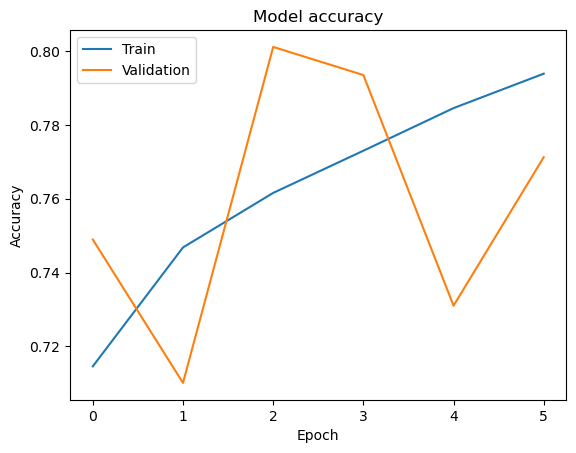

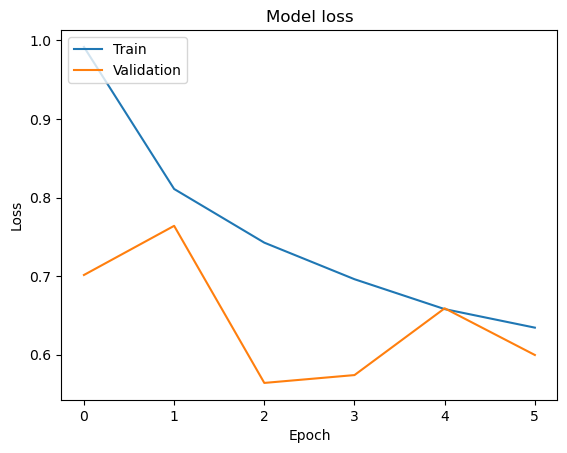

Validation Accuracy:  0.7976585030555725
1170/1170 [==============================] - 13s 10ms/step
Precision: 0.8518913098901516, Recall: 0.7976585052924196, F1 Score: 0.8186244111921558


In [22]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np

# Check if best_params are correctly set
if 'lstm_units' in best_params and 'batch_size' in best_params and 'learning_rate' in best_params:
    # Early Stopping Callback to avoid overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')

    # Create the final model using the best parameters
    final_model = create_model(best_params['lstm_units'], best_params['learning_rate'])

    # Train the model with the entire dataset
    history = final_model.fit(
        [padded_sequences, sentiment_scores], 
        encoded_labels, 
        epochs=10, 
        batch_size=best_params['batch_size'], 
        validation_split=0.2, 
        callbacks=[early_stopping, model_checkpoint],
        class_weight=class_weight_dict  # Use if addressing class imbalance
    )

    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Load the best model and evaluate on validation set
    final_model.load_weights('best_model.h5')
    # Make sure X_val, sentiment_val, and y_val are defined and correspond to your validation set
    val_loss, val_accuracy = final_model.evaluate([X_val, sentiment_val], y_val, verbose=0)
    print("Validation Accuracy: ", val_accuracy)

    # Optional: Calculate additional metrics like F1 score, precision, and recall on validation set
    # Note: You need to modify this part to suit your label format and requirements
    y_val_pred = final_model.predict([X_val, sentiment_val])
    y_val_pred = np.argmax(y_val_pred, axis=1)
    y_val_true = np.argmax(y_val.values, axis=1)
    precision, recall, f1 = calculate_metrics(y_val_true, y_val_pred)
    print("Precision: {}, Recall: {}, F1 Score: {}".format(precision, recall, f1))
else:
    print("best_params not correctly set. Please check the hyperparameter tuning process.")




final test with lux 

In [25]:

import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
import numpy as np
from sklearn.metrics import classification_report

# Load test dataset
test_data_path = '/Users/patrickbendorffschwebel/Desktop/Anvendt-kode/anvendt-exam/mappe uden navn 2/Luxury_Beauty.json'
test_data = pd.read_json(test_data_path, lines=True, nrows=25000)

# Preprocess, tokenize, and prepare test data
# Ensure to include the preprocess_text and cat_y functions, tokenizer, and sia from your existing code
test_data['processed_reviewText'] = test_data['reviewText'].apply(preprocess_text)

# Convert reviewText to string before applying polarity_scores
test_data['Sentiment_Score'] = test_data['reviewText'].apply(lambda x: sia.polarity_scores(str(x))['compound'])

test_sequences = tokenizer.texts_to_sequences(test_data['processed_reviewText'])
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_length)

test_labels = test_data['overall'].apply(cat_y)
test_encoded_labels = pd.get_dummies(test_labels)

test_sentiment_scores = np.array(test_data['Sentiment_Score']).reshape(-1, 1)

# Load the best model
final_model = load_model('best_model.h5')

# Evaluate the model on the test data
test_loss, test_accuracy = final_model.evaluate([test_padded_sequences, test_sentiment_scores], test_encoded_labels, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predict and calculate precision, recall, and F1-score
y_test_pred = final_model.predict([test_padded_sequences, test_sentiment_scores])
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_true = np.argmax(test_encoded_labels.values, axis=1)

# Generate and print classification report
report = classification_report(y_test_true, y_test_pred_classes, target_names=['high', 'low', 'neutral'])
print(report)



Test Accuracy: 0.7871
782/782 [==============================] - 10s 12ms/step
              precision    recall  f1-score   support

        high       0.93      0.85      0.89     19770
         low       0.57      0.68      0.62      3440
     neutral       0.20      0.32      0.24      1790

    accuracy                           0.79     25000
   macro avg       0.57      0.61      0.58     25000
weighted avg       0.83      0.79      0.80     25000

